# 	Interactive exploration with widgets and dashboards

Here, we will use a motivating example that looks at CO$_2$ data to demonstrate linear regression to introduce:
- [Jupyter Widgets](https://ipywidgets.readthedocs.io/en/latest/index.html) and 
- [Voilà dashboards](https://voila.readthedocs.io/en/latest/?badge=latest)

The example we follow is adapted from the [Intro-Jupyter tutorial from ICESat-2Hackweek](https://github.com/ICESAT-2HackWeek/intro-jupyter), which has contributions from: [Shane Grigsby (@espg)](https://github.com/espg), [Lindsey Heagy (@lheagy)](https://github.com/lheagy), [Yara Mohajerani (@yaramohajerani)](https://github.com/yaramohajerani), and [Fernando Pérez (@fperez)](https://github.com/fperez). 

# Motivating example: CO$_2$ at Mauna Loa

> _The climate emergency is one of the most pressing issues of our time. At this pivotal moment, the decisions and actions we take today will reverberate beyond our own borders and lifetimes._ -- [UBC Climate Emergency Engagement](https://climateemergency.ubc.ca/)

Carbon Dioxide (CO2) is a greenhouse gas, and significant contributor to the warming of the climate. It is an important input into climate models, which we use to make predictions about possible future climate scenarios, and sometimes to make policy decisions, including carbon taxes. 

**Question:** Based on historical CO$_2$ data, can we estimate what CO$_2$ concentrations will be in the future? 


### Learning Goals
- explore the idea of "learning": building a model from data that lets us make predictions 
- discuss the limitations of models
- provide motivation for linear regression, a simple, but powerful method for estimating a linear model of data

### Context

Scripps institute of Oceanography has a research station at Mauna Loa in Hawaii where they have been measuring atmospheric CO2 since 1958.  

<img src="https://scrippsco2.ucsd.edu/assets/images/mlo_station_map.png" align="center">

**Data Source**

C. D. Keeling, S. C. Piper, R. B. Bacastow, M. Wahlen, T. P. Whorf, M. Heimann, and  H. A. Meijer, Exchanges of atmospheric CO2 and 13CO2 with the terrestrial biosphere and  oceans from 1978 to 2000.  I. Global aspects, SIO Reference Series, No. 01-06, Scripps  Institution of Oceanography, San Diego, 88 pages, 2001. https://scrippsco2.ucsd.edu/data/atmospheric_co2/primary_mlo_co2_record.html     

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
from matplotlib import rcParams
rcParams["font.size"] = 14

## Load, clean and plot the data

We first do some light cleaning to remove rows with missing data, and then plot up our data set. This dataset like many others in climate, depends on the season. For example, over the year, CO$_2$ usually [hits a peak in the spring](https://scripps.ucsd.edu/programs/keelingcurve/2013/06/04/why-does-atmospheric-co2-peak-in-may/), but we are interested in the long term year to year variation, not seasonal. As a result, we are using the seasonally adjusted data. 

For a description of the data types we can consider, please see the [description from Scripps](https://scrippsco2.ucsd.edu/data/atmospheric_co2/primary_mlo_co2_record.html). 

In [3]:
co2_data_source = "./data/monthly_in_situ_co2_mlo.csv"
co2_data_full = pd.read_csv(
    co2_data_source, skiprows=np.arange(0, 56), na_values="-99.99"
)

co2_data_full.columns = [
    "year", "month", "date (int)", "date", "co2", "seasonally adjusted",
    "fit", "seasonally adjusted fit", "co2 filled", "seasonally adjusted filled" 
]

co2_data = co2_data_full.dropna()

In [4]:
def get_data_between(data=co2_data, date_range=None, data_type="seasonally adjusted"):
    """
    A function to fetch data between year_min and year_max  
    """
    if date_range is None:
        date_range = data["date"].min(), data["date"].max()

    # find the data between the minimimum and maximum years
    indices = (data["date"] >= date_range[0]) & (data["date"] <= date_range[1]) 
    return data["date"][indices], data[data_type][indices]

In [5]:
def plot_co2_data(data=co2_data, date_range=None, data_type="seasonally adjusted", ax=None):
    """
    A function that we can use to plot data between year_min and year_max
    """
    
    # create a figure if one isn't supplied
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(8, 5))
        
    dates, data_between = get_data_between(data, date_range, data_type)
        
    # plot data
    ax.plot(dates, data_between, '.',  ms=8)
    ax.grid()
    ax.set_xlabel(f"Year")
    ax.set_ylabel(f"CO$_2$ [ppm]")
    
    return ax

<AxesSubplot:xlabel='Year', ylabel='CO$_2$ [ppm]'>

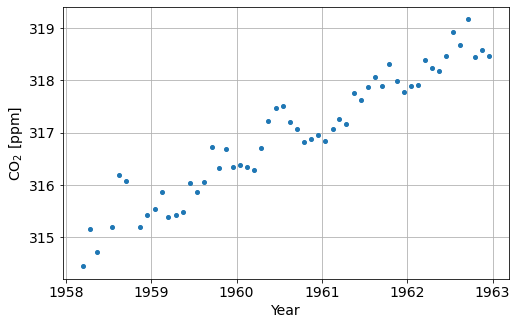

In [7]:
plot_co2_data(co2_data, [1958, 1963])

## Building models from data: 

### Part 1: Focus on the first 5 years

**Question:** If the trend between 1958 and 1963 continues, what would we expect the CO$_2$ concentration to be in January, 2030?  

#### Approach - The "eyeball" norm - with widgets!

- using the widgets below, estimate a slope and intercept of a line that fits the data
- the `slope` indicates the rate of CO$_2$ accumulation per year
- the `intercept` is the estimated concentration of CO$_2$ at the first point we consider

In [8]:
import ipywidgets as widgets

In [11]:
def add_line(dates, slope, intercept, ax=None, label=None):
    """
    A function to add a line to a plot
    """    
    # create a figure if one isn't supplied
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(8, 5))
    
    y = slope * (dates - np.min(dates)) + intercept
    ax.plot(dates, y, label=label)

In [9]:
def plot_fit_co2_data(slope, intercept, year_min=1958, year_max=2020, data_type="seasonally adjusted"):
    """
    This function creates an interactive widget where we can fit a curve to data
    """
    fig, ax = plt.subplots(1, 1, figsize=(8, 5))
    plot_co2_data(co2_data, [year_min, year_max], data_type, ax=ax)
    add_line(np.r_[year_min, year_max], slope, intercept, ax=ax)
    return ax

In [27]:
year_min_early = 1958
year_max_early = 1963

w_co2_early = widgets.interactive(
    plot_fit_co2_data, 
    slope=widgets.FloatSlider(
        min=0, max=5, step=0.1, value=2
    ),
    intercept=widgets.FloatSlider(
        min=co2_data["seasonally adjusted"].min()-5, 
        max=co2_data["seasonally adjusted"].min()+5, 
        step=0.25
    ),
    year_min=widgets.fixed(year_min_early),
    year_max=widgets.fixed(year_max_early),
    data_type=widgets.fixed("seasonally adjusted")
)
w_co2_early

interactive(children=(FloatSlider(value=2.0, description='slope', max=5.0), FloatSlider(value=309.44, descript…

### Make a prediction 

Based on your estimated slope and intercept values: what do you estimate the CO$_2$ concentration would be in 2030? 

In [13]:
def predict_co2(slope, intercept, initial_date, prediction_date):
    """
    based on an estimated slope, and intercept use a linear 
    model to predict CO2 concentration
    """
    return slope * (prediction_date-initial_date) + intercept

In [17]:
year_predict = 2030

predicted_co2_early = predict_co2(
    w_co2_early.kwargs["slope"], w_co2_early.kwargs["intercept"], 
    year_min_early, year_predict
)

print(
    f"Predicted CO2 in {year_predict}: {predicted_co2_early:1.2f} ppm"
)


Predicted CO2 in 2030: 379.49 ppm


### Part 2: Focus on the most recent 5 years

**Question:** If the trend between 2015 and 2020 continues, what would we expect the CO$_2$ concentration to be in January, 2030?  

In [18]:
year_min_recent = 2015
year_max_recent = 2020

w_co2_recent = widgets.interactive(
    plot_fit_co2_data, 
    slope=widgets.FloatSlider(
        min=0, max=5, step=0.1, value=2
    ),
    intercept=widgets.FloatSlider(
        min=co2_data["seasonally adjusted"].max()-20, 
        max=co2_data["seasonally adjusted"].max(), 
        step=0.25
    ),
    year_min=widgets.fixed(year_min_recent),
    year_max=widgets.fixed(year_max_recent),
    data_type=widgets.fixed("seasonally adjusted")
)
w_co2_recent

interactive(children=(FloatSlider(value=2.0, description='slope', max=5.0), FloatSlider(value=393.35, descript…

In [19]:
predicted_co2_recent = predict_co2(
    w_co2_recent.kwargs["slope"], w_co2_recent.kwargs["intercept"], 
    year_min_recent, year_predict
)

print(
    f"Predicted CO2 in {year_predict}: {predicted_co2_recent:1.2f} ppm"
)


Predicted CO2 in 2030: 440.10 ppm


In [20]:
print(
    f"Predicted CO2 in {year_predict} using data from: \n"
    f"  {year_min_early} - {year_max_early}: {predicted_co2_early:1.2f} ppm,"
    f" with a slope of {w_co2_early.kwargs['slope']:1.2f} ppm/year \n"
    f"  {year_min_recent} - {year_max_recent}: {predicted_co2_recent:1.2f} ppm,"
    f" with a slope of {w_co2_recent.kwargs['slope']:1.2f} ppm/year \n"
)

Predicted CO2 in 2030 using data from: 
  1958 - 1963: 379.49 ppm, with a slope of 0.90 ppm/year 
  2015 - 2020: 440.10 ppm, with a slope of 2.70 ppm/year 



## before looking at the next plot(!): Why are these estimates so different? 

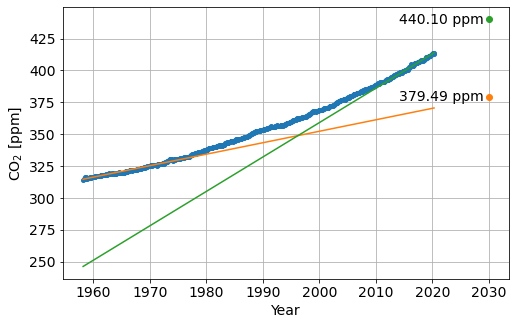

In [21]:
def plot_predictions(xlim=None, ylim=None):
    ax = plot_co2_data()

    # add predictions
    add_line(
        co2_data["date"], w_co2_early.kwargs["slope"], w_co2_early.kwargs["intercept"],
        label = f"{year_min_early} - {year_max_early} prediction", ax=ax
    )

    add_line(
        co2_data["date"], w_co2_recent.kwargs["slope"], 
        w_co2_recent.kwargs["intercept"] - (year_min_recent-co2_data["date"].min())*w_co2_recent.kwargs["slope"], # adjust the intercept to use 1958
        label = f"{year_min_recent} - {year_max_recent} prediction", ax=ax
    ) 

    # add our predictions 
    ax.plot(year_predict, predicted_co2_early, 'C1o')
    ax.text(
        year_predict - 1, predicted_co2_early, 
        f"{predicted_co2_early:1.2f} ppm", ha="right", va="center"
    )

    ax.plot(
        year_predict, predicted_co2_recent, 'C2o'
    )
    ax.text(
        year_predict - 1, predicted_co2_recent, 
        f"{predicted_co2_recent:1.2f} ppm", ha="right", va="center"
    )
    
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
plot_predictions()

## Discussion:

**Q1:** Within small enough regions, the data follow an approximately linear trend, so a linear model has some predictive power. In the following cell, we have a widget where you can zoom in on the plot. 
- Out to which year would you trust the model built with the data from 1958 - 1963? 
- Where does it start to break down?

**Q2:** How far out would you trust our predictions with data from 2015 - 2020? Would you trust our model to predict CO$_2$ in the year 2050? 

**Q3:** How might you approach building a model to fit all of our data? 

